<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 
    20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  PROJECT 2: Decision Tree
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Breast Cancer Wisconsin Dataset 

</div>

#### Tập dữ liệu lớp nhị phân: [The UCI Breast Cancer Wisconsin (Diagnostic) dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)
---

### Tải thư viện cần thiết

In [1]:
# Thư viện để tải dữ liệu
from ucimlrepo import fetch_ucirepo 

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import joblib

# Các thư viện trực quan
import graphviz
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

### Đọc dữ liệu

In [2]:
# Tải dữ liệu
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# Dữ liệu (dưới dạng dataframe của pandas)
X = breast_cancer_wisconsin_diagnostic.data.features  
y = breast_cancer_wisconsin_diagnostic.data.targets 

In [3]:
X.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
y.head()

,Diagnosis
0,M
1,M
2,M
3,M
4,M


## 1. Chuẩn bị dữ liệu

Tập dữ liệu được chia thành các tập con như sau:
- **feature_train**: chứa các mẫu dùng để huấn luyện.
- **label_train**: nhãn tương ứng với các mẫu trong feature_train.
- **feature_test**: chứa các mẫu dùng để kiểm tra, có cấu trúc giống feature_train.
- **label_test**: nhãn tương ứng với các mẫu trong feature_test.

Quá trình chia dữ liệu cần được đảm bảo:
- Xáo trộn dữ liệu trước khi chia.
- Chia dữ liệu theo phương pháp phân tầng (stratified).
- Các tham số khác (nếu có) nên giữ nguyên giá trị mặc định.

Dữ liệu được chia theo bốn tỷ lệ: 40/60, 60/40, 80/20, và 90/10, tổng cộng là 16 tập con.

In [5]:
def split_data(X, y, test_size):
    feature_train, feature_test, label_train, label_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42, shuffle=True)
    return feature_train, feature_test, label_train, label_test

proportions = {"40/60": 0.6, "60/40": 0.4, "80/20": 0.2, "90/10": 0.1}
data_splits = {}
for ratio, test_size in proportions.items():
    feature_train, feature_test, label_train, label_test = split_data(X, y, test_size)
    data_splits[ratio] = (feature_train, feature_test, label_train, label_test)

Trực quan hóa phân bố các lớp trong tất cả các tập dữ liệu (tập dữ liệu ban đầu, các tập huấn luyện và các tập kiểm tra) trong tất cả các tỷ lệ để chứng minh rằng chúng đã được chuẩn bị một cách phù hợp.

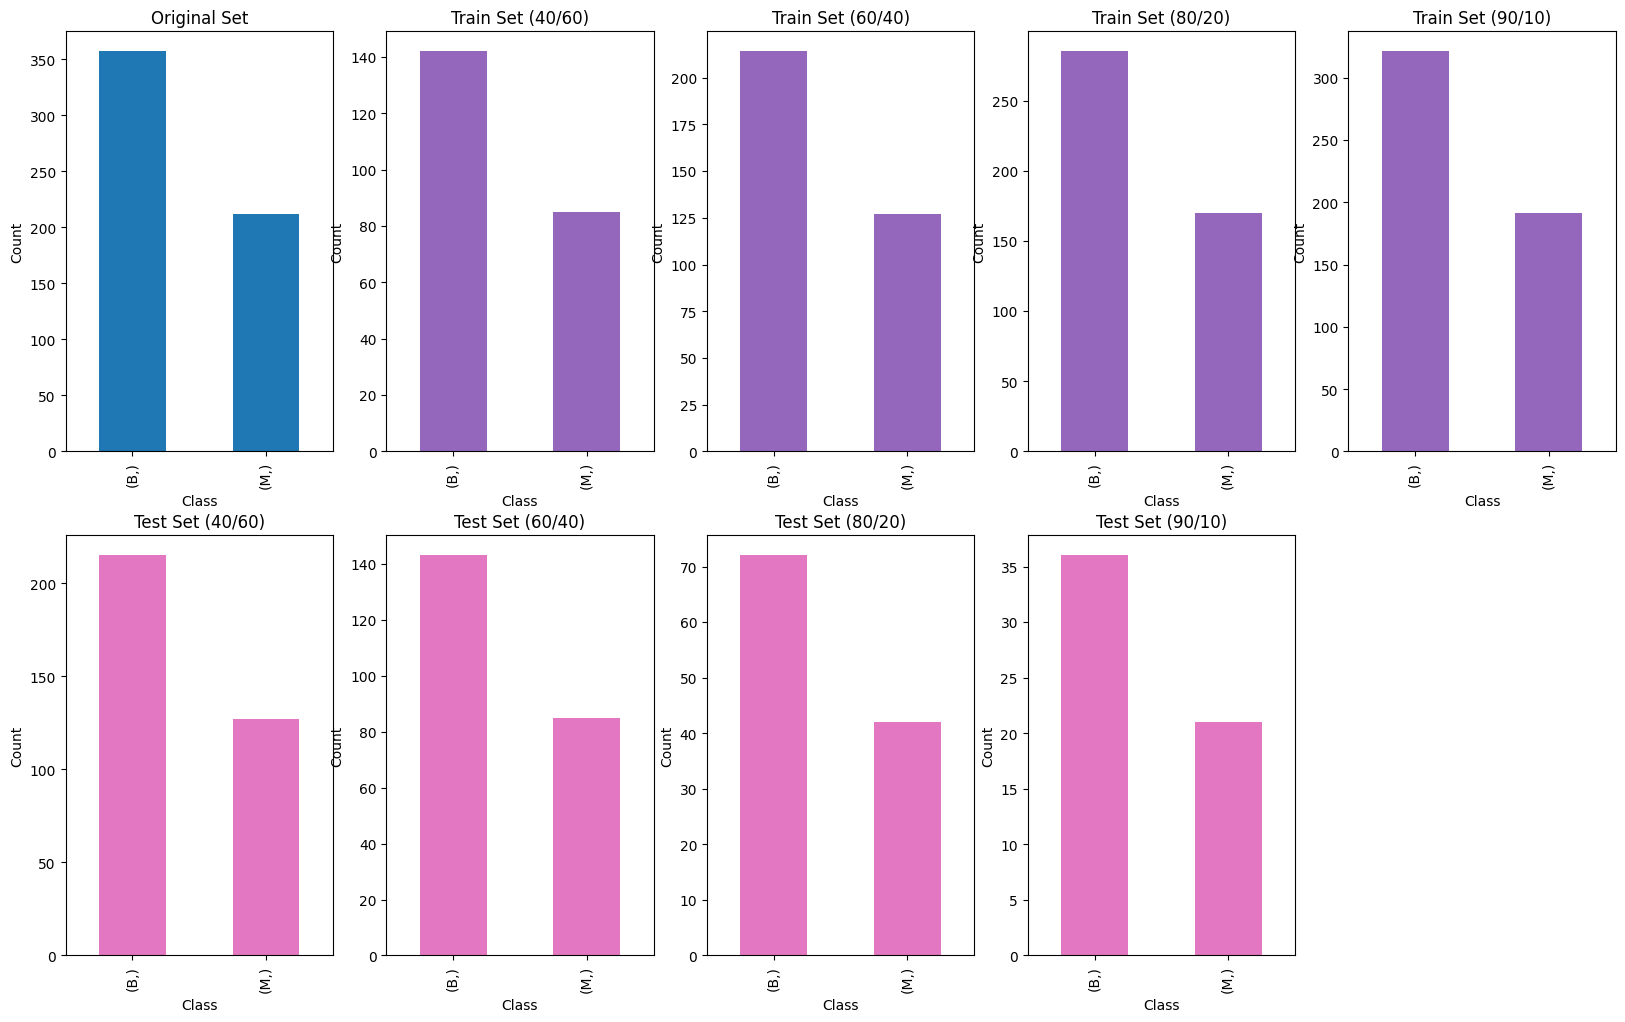

In [6]:
# Phân phối lớp trong dữ liệu gốc
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
y.value_counts().plot(kind='bar', color='#1f77b4', ax=axes[0,0])
axes[0, 0].set_title("Original Set")
axes[0, 0].set_xlabel("Class")
axes[0, 0].set_ylabel("Count")

# Biểu đồ cho mỗi tập huấn luyện và kiểm tra
for i, (key, (feature_train, feature_test, label_train, label_test)) in enumerate(data_splits.items()):
    # Phân phối lớp cho tập huấn luyện
    label_train.value_counts().plot(kind='bar', color='#9467bd', ax=axes[0, i+1])
    axes[0, i+1].set_title(f"Train Set ({key})")
    axes[0, i+1].set_xlabel("Class")
    axes[0, i+1].set_ylabel("Count")
    
    # Phân phối lớp cho tập kiểm tra
    label_test.value_counts().plot(kind='bar', color='#e377c2', ax=axes[1, i])
    axes[1, i].set_title(f"Test Set ({key})")
    axes[1, i].set_xlabel("Class")
    axes[1, i].set_ylabel("Count")

axes[1, 4].axis('off')
plt.show()

## 2. Xây dựng cây quyết định

Thực hiện các thí nghiệm trên các tỷ lệ huấn luyện/kiểm tra đã được liệt kê ở trên.

Huấn luyện mô hình **sklearn.tree.DecisionTreeClassifier** (sử dụng thông tin đạt được) cho mỗi tập huấn luyện và trực quan hóa cây quyết định kết quả bằng Graphviz.

In [7]:
# Thêm đường dẫn đến Graphviz
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
# Máy không tìm thấy đường dẫn nên phải tự thêm đường dẫn

# Tạo thư mục lưu ảnh
output_dir = "Decision_Tree_Visualizations_BreastCancer_Dataset"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [8]:
# Lặp qua các tỷ lệ huấn luyện/kiểm tra
for i, (key, (feature_train, feature_test, label_train, label_test)) in enumerate(data_splits.items()):
    # Khởi tạo và huấn luyện mô hình Decision Tree Classifier
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(feature_train, label_train)

    # Lưu mô hình đã huấn luyện
    model_filename = f"decision_tree_model_{key.replace('/', '_')}.joblib"
    joblib.dump(clf, model_filename)

    # Sử dụng Graphviz để trực quan hóa cây
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                    feature_names=feature_train.columns, 
                                    class_names=np.unique(label_train).astype(str), 
                                    filled=True, rounded=True)
    graph = graphviz.Source(dot_data)
    print(key)
    display(graph)
    
    # Lưu vào thư mục ảnh
    key = key.replace("/", "-")  # Thay ký tự '/' bằng '-'
    file_name = f"{key}_max_depth=None.svg"
    file_path = os.path.join(output_dir, file_name)
    graph.render(file_path, format="svg", cleanup=True) # Lưu Decision Tree vào thư mục dưới dạng .svg

40/60


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## 3. Đánh giá

Đối với mỗi mô hình **DecisionTreeClassifier** trên, dự đoán các mẫu trong tập kiểm tra tương ứng và tạo báo cáo sử dụng classification_report và confusion_matrix.

40/60


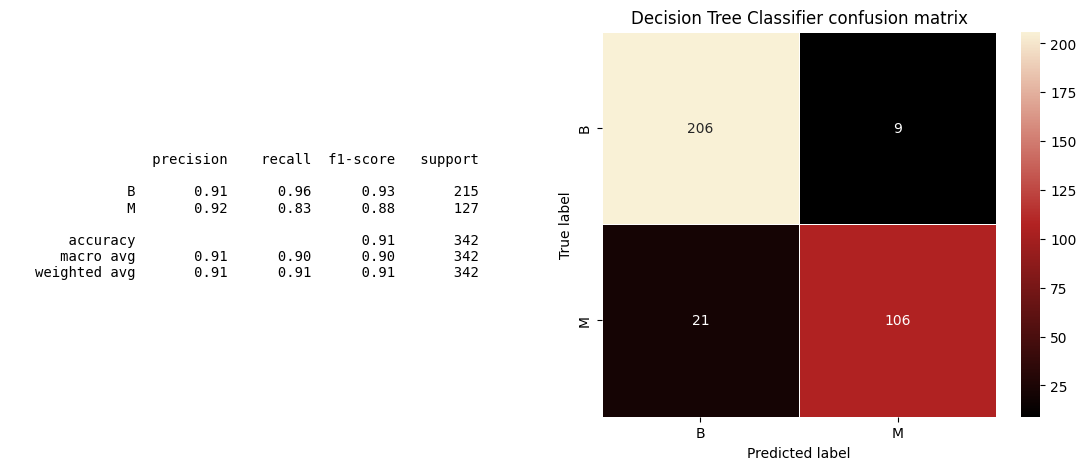

60/40


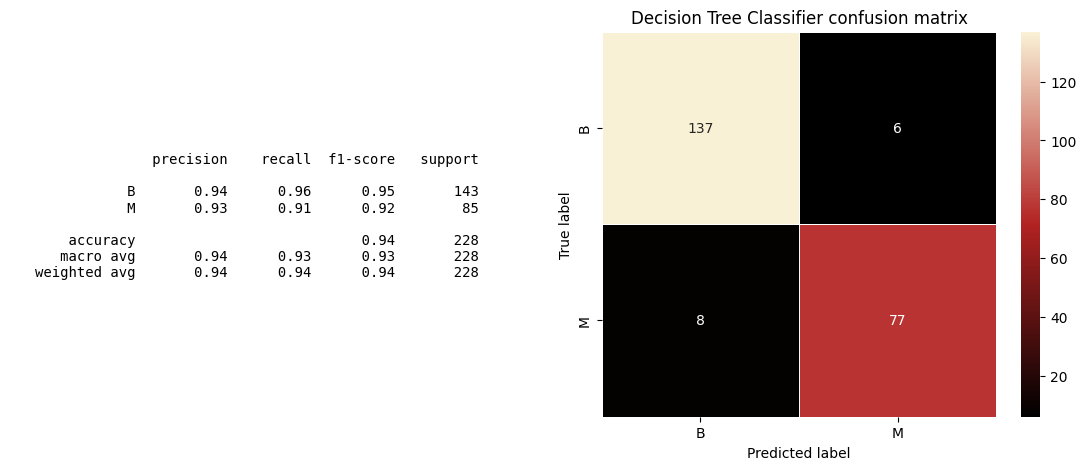

80/20


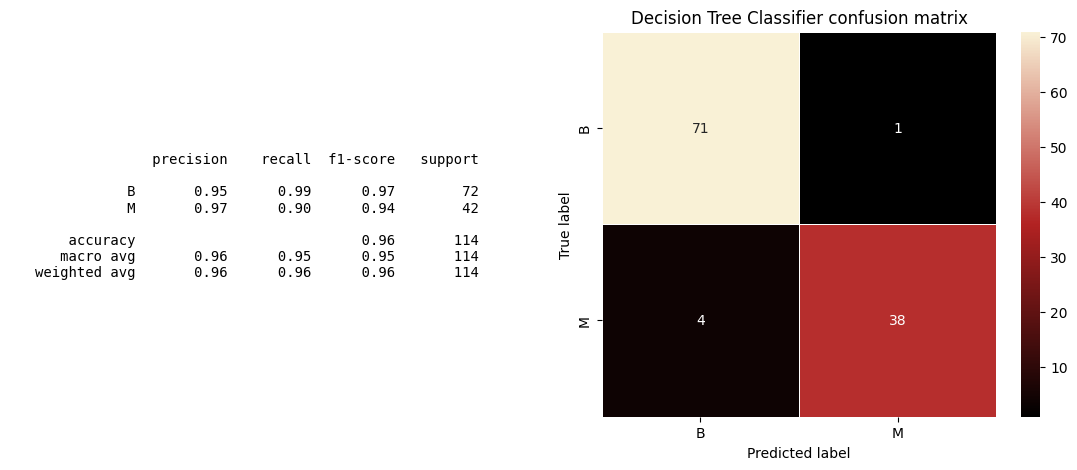

90/10


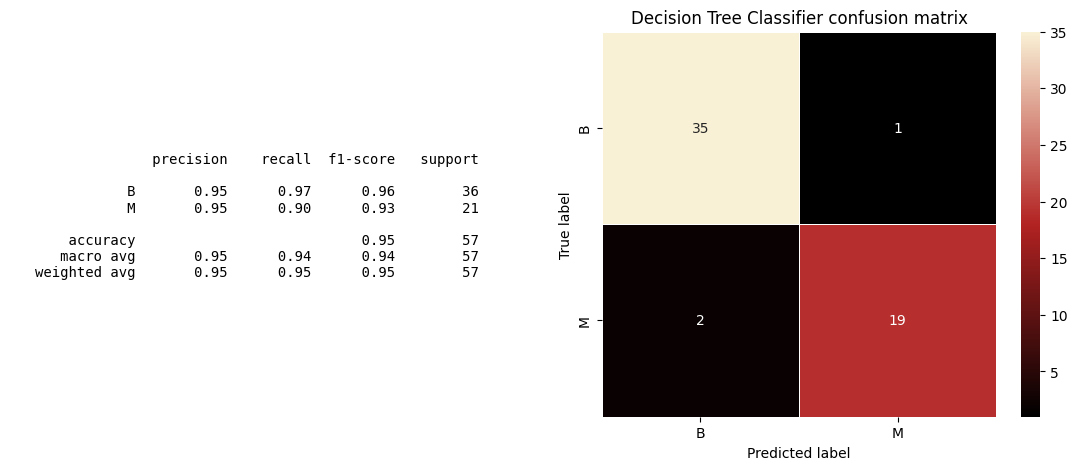

In [9]:
# Tạo bảng màu đen đỏ 
colors = ["black", "#B22222", "#F9F1D6"]
cmap = LinearSegmentedColormap.from_list("black_red", colors, N=256)

# Lặp qua các tỷ lệ huấn luyện/kiểm tra
for i, (key, (feature_train, feature_test, label_train, label_test)) in enumerate(data_splits.items()):
    # Tải mô hình đã huấn luyện
    model_filename = f"decision_tree_model_{key.replace('/', '_')}.joblib"
    clf = joblib.load(model_filename)

    # Dự đoán trên tập kiểm tra
    y_pred = clf.predict(feature_test)

    # Tạo báo cáo phân loại
    report = classification_report(label_test, y_pred)

    # Tạo ma trận nhầm lẫn
    matrix = confusion_matrix(label_test, y_pred)
    
    print(key)

    # Tạo figure và subplot cho ma trận nhầm lẫn và báo cáo phân loại
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 hàng, 2 cột

    # In báo cáo phân loại vào subplot đầu tiên
    ax_report = axes[0]  # Chọn subplot đầu tiên cho báo cáo phân loại
    ax_report.text(0.5, 0.5, report, ha='center', va='center', fontsize=10, wrap=True, family='monospace') 
    ax_report.axis('off')  # Tắt trục của báo cáo

    # Vẽ confusion matrix vào subplot thứ hai
    ax_cm = axes[1]  # Chọn subplot thứ hai cho ma trận nhầm lẫn
    sns.heatmap(matrix, annot=True, fmt='g', cmap=cmap, 
               linewidths=0.5, linecolor='white',
               xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax_cm)
    ax_cm.set_title("Decision Tree Classifier confusion matrix")
    ax_cm.set_xlabel('Predicted label')
    ax_cm.set_ylabel('True label')

    plt.show()

## 4. Độ sâu và độ chính xác của cây quyết định

Tập trung vào tập huấn luyện và kiểm tra với tỷ lệ 80/20. Xem xét ảnh hưởng của độ sâu cây quyết định đối với độ chính xác phân loại.

Điều chỉnh tham số max_depth để thay đổi độ sâu tối đa của cây quyết định. Thử các giá trị sau cho tham số max_depth: None, 2, 3, 4, 5, 6, 7.

Thực hiện các yêu cầu sau:
- Trực quan hóa các cây quyết định sử dụng Graphviz cho mỗi giá trị max_depth.
- Báo cáo giá trị accuracy_score (trên tập kiểm tra) của mô hình cây quyết định với các giá trị khác nhau của tham số max_depth và điền vào bảng sau:

| max_depth| None| 2| 3| 4| 5| 6| 7|
|-|-|-|-|-|-|-|-|
|Accuracy| | | | | | | |

- Cung cấp biểu đồ và đưa ra nhận xét về các thống kê đã báo cáo ở trên.

Đầu tiên là trực quan hóa các cây quyết định sử dụng Graphviz cho mỗi giá trị max_depth.

max_depth = None


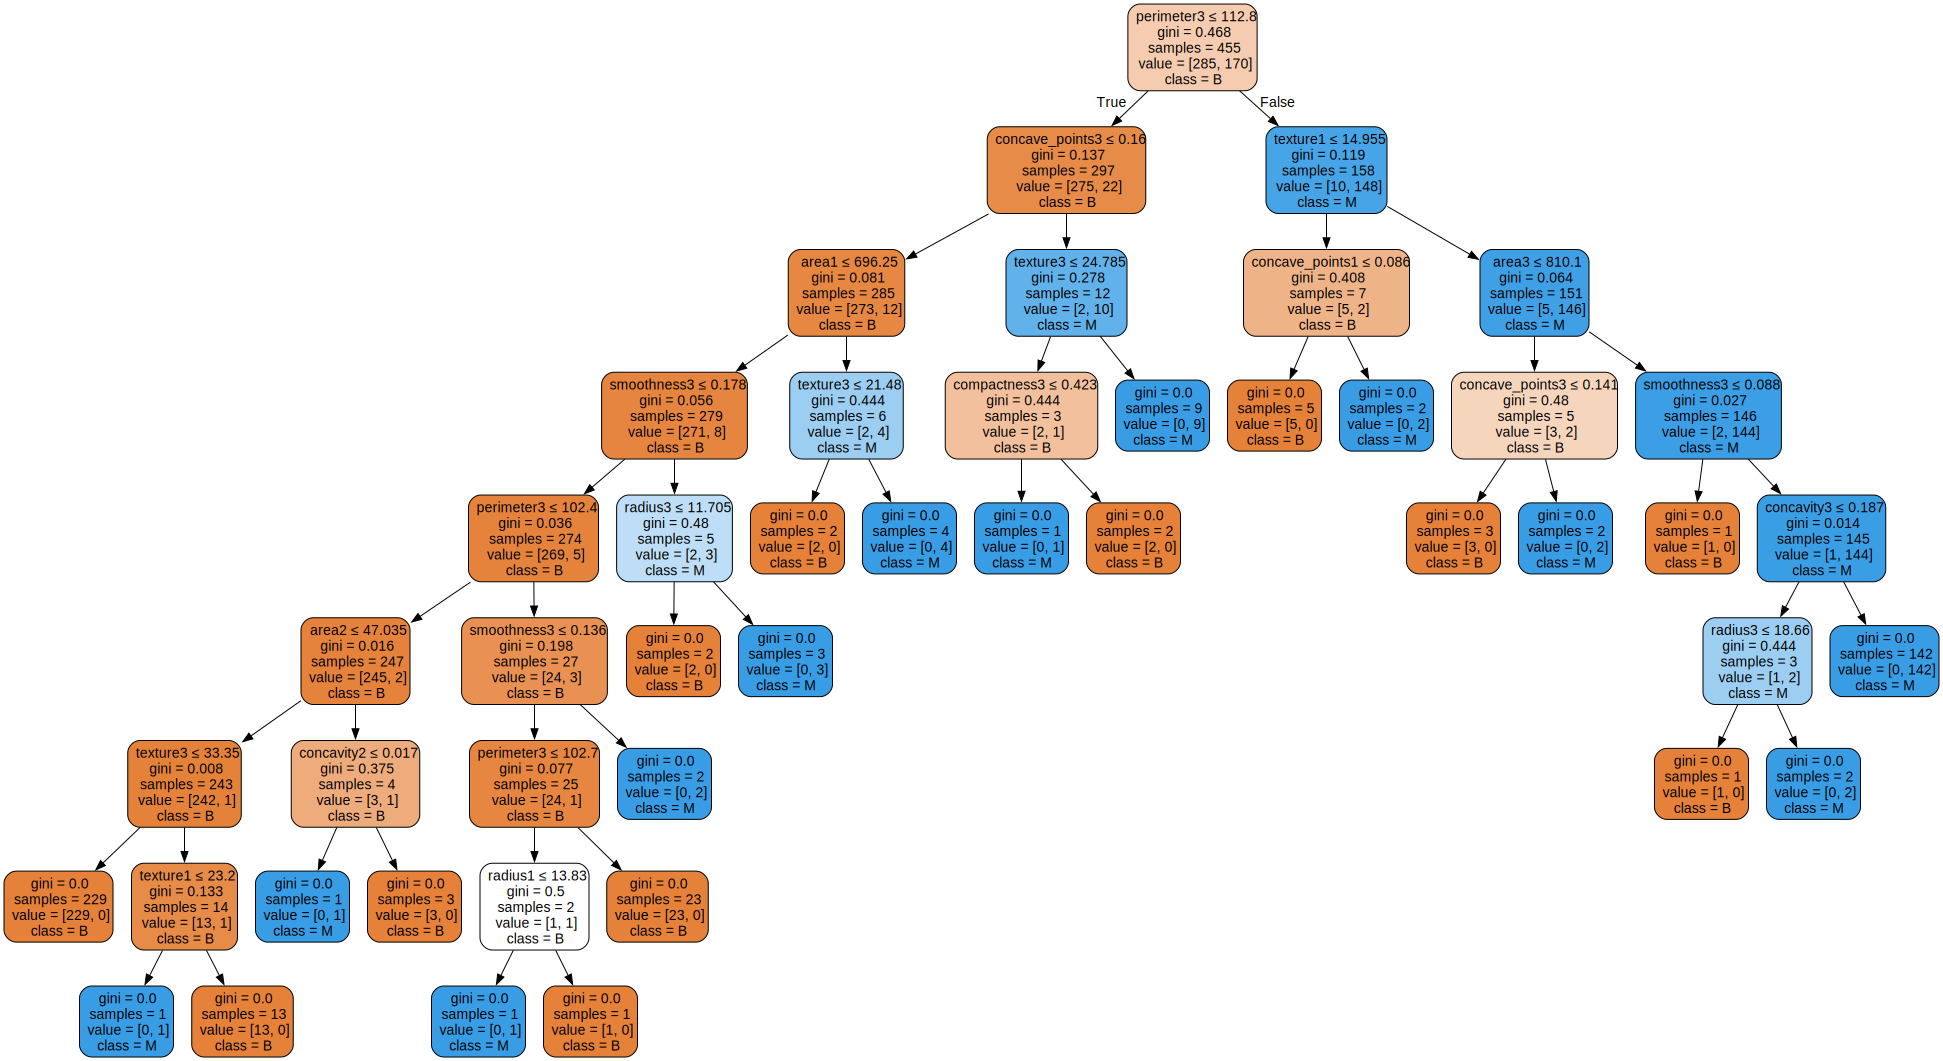

max_depth = 2


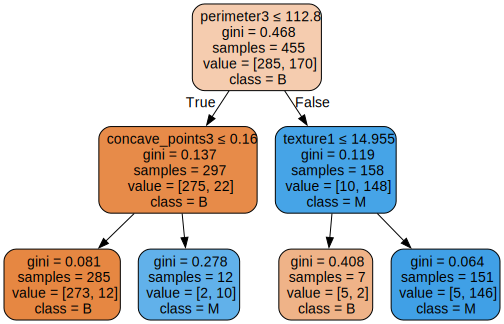

max_depth = 3


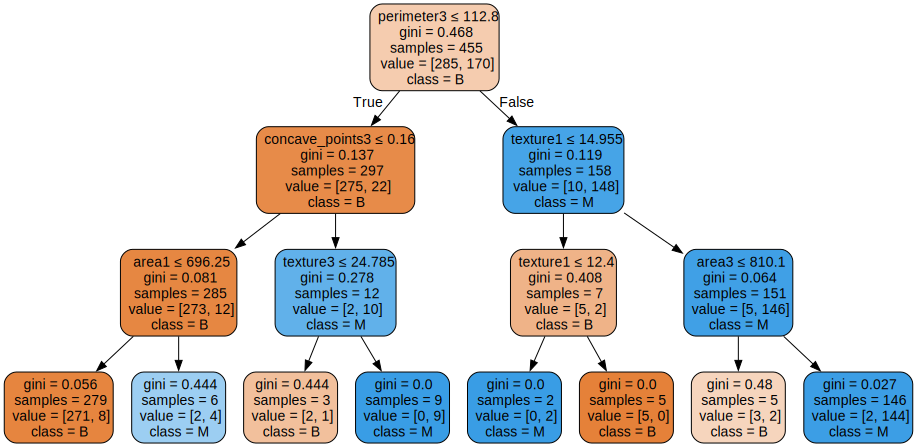

max_depth = 4


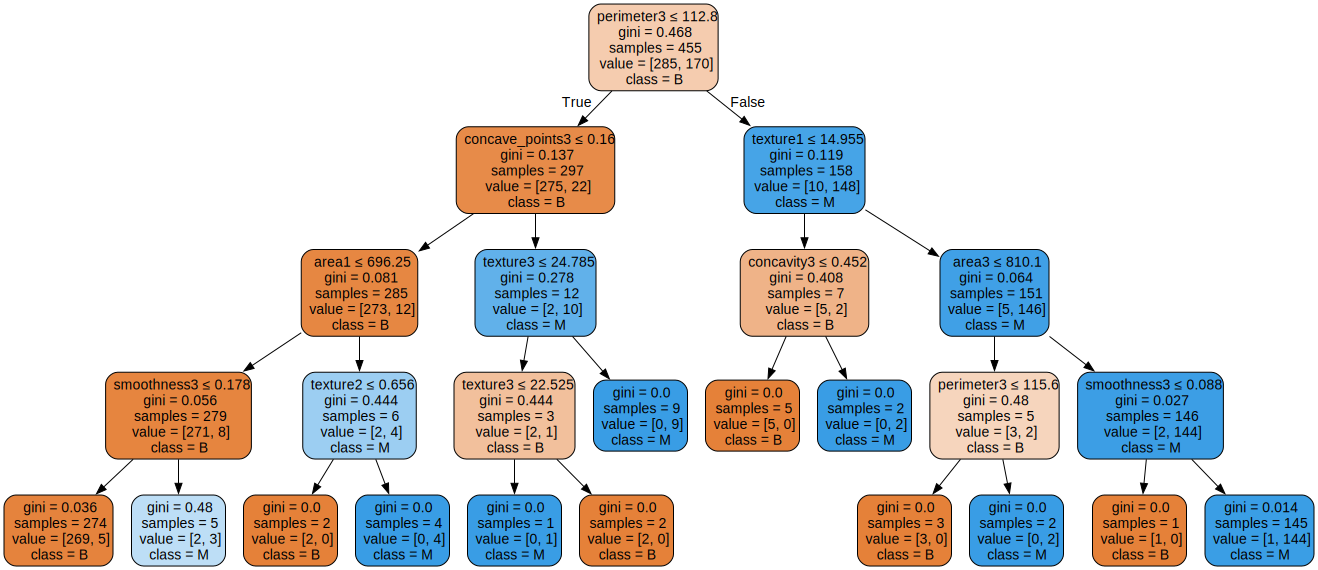

max_depth = 5


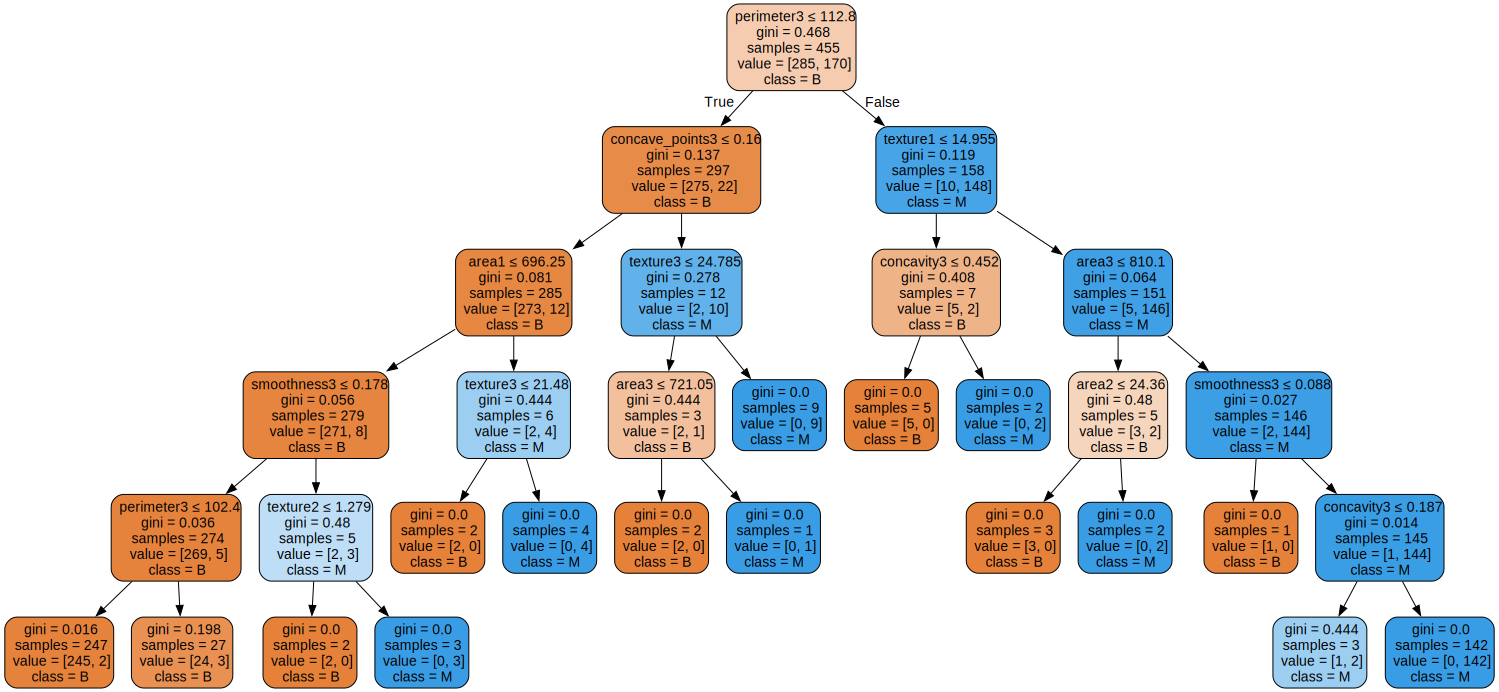

max_depth = 6


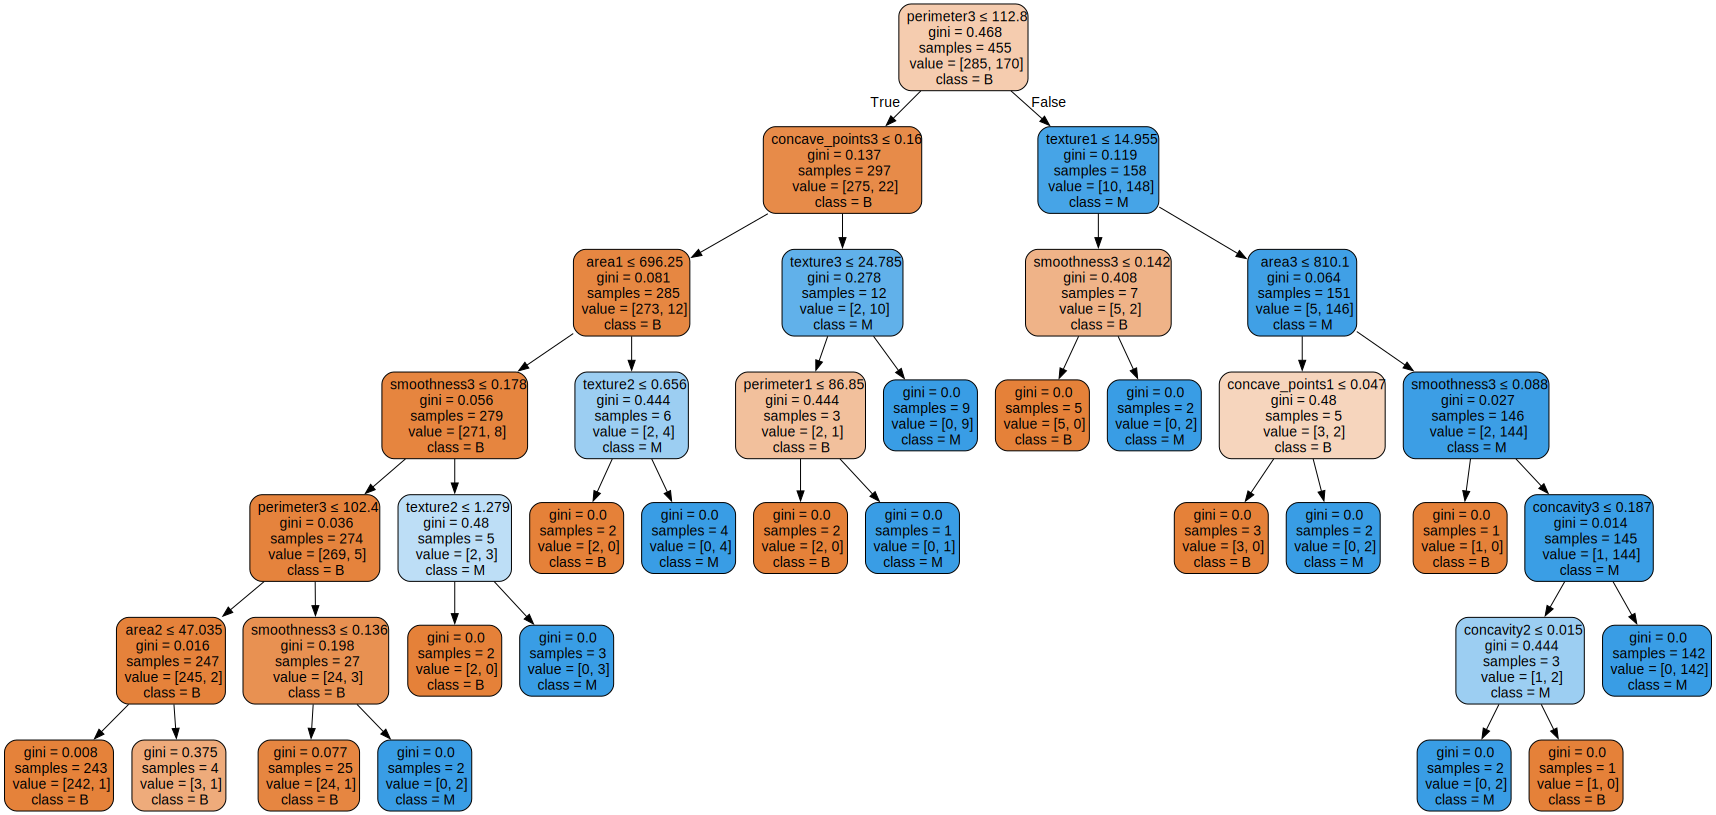

max_depth = 7


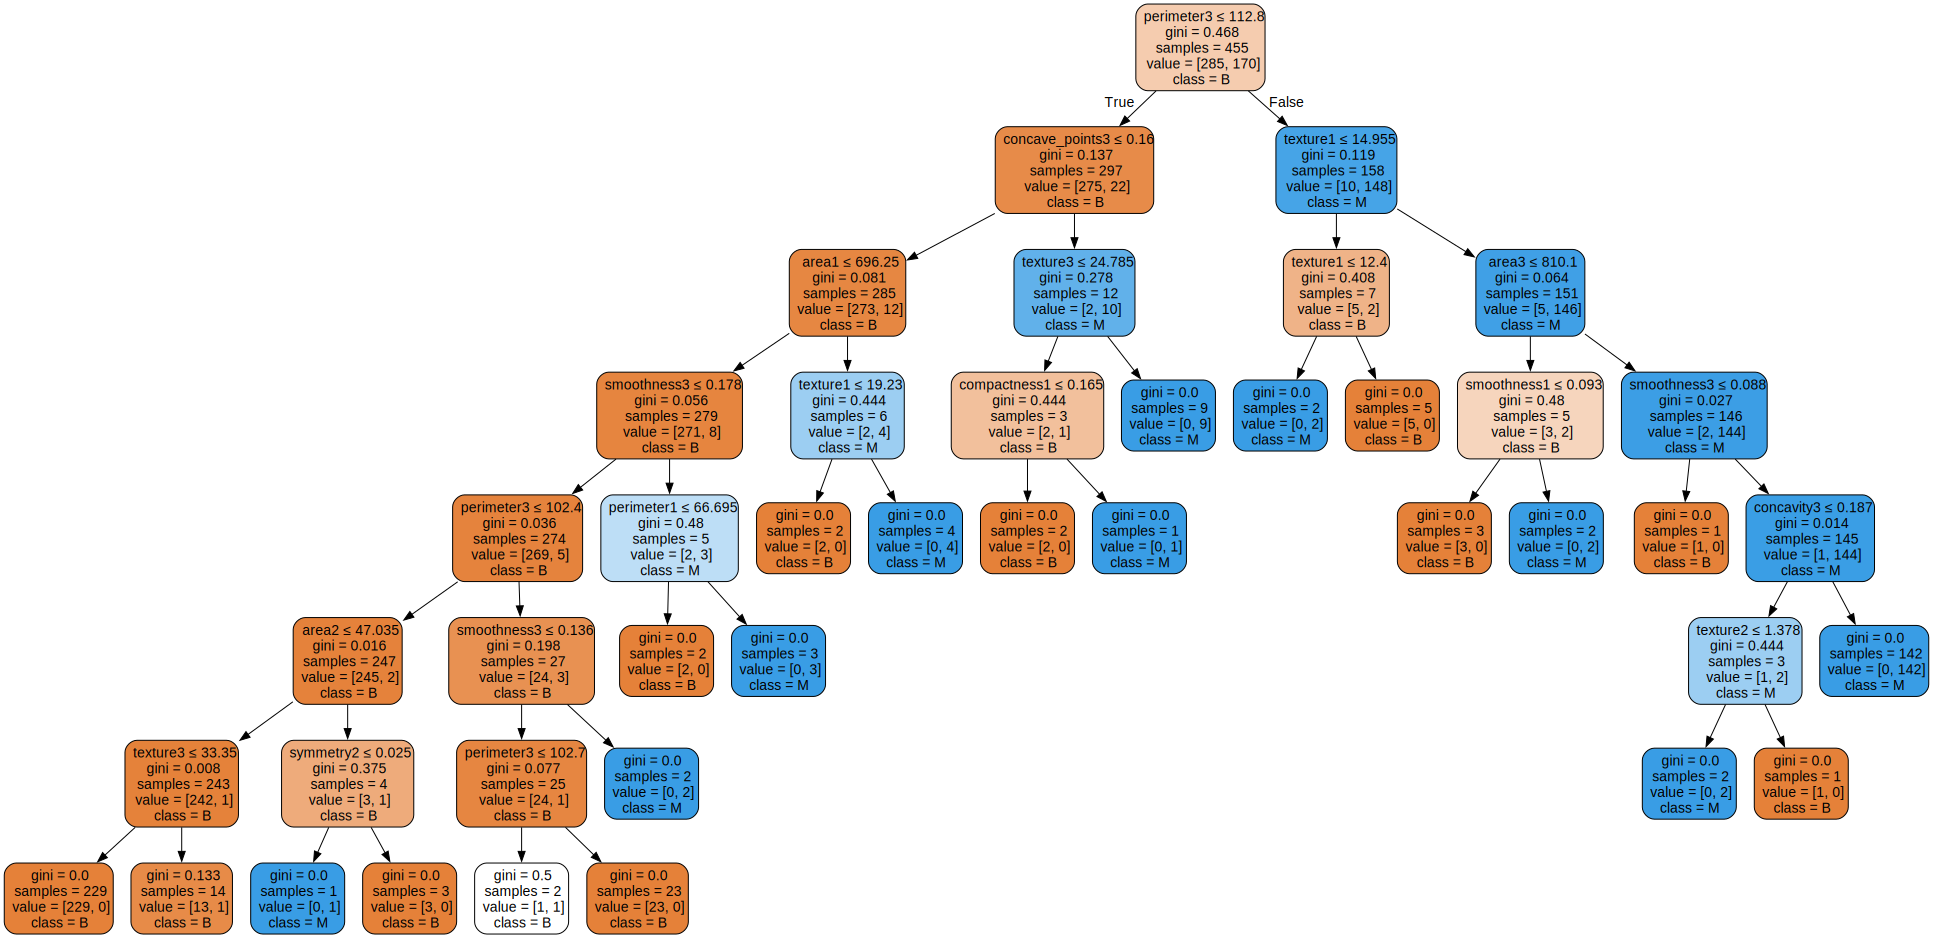

In [10]:
# Các giá trị của max_depth cần thử
max_depth_values = [None, 2, 3, 4, 5, 6, 7]

# Tạo danh sách lưu trữ độ chính xác
accuracy_scores = []

# Lấy các tập đặc trưng và nhãn cho tỷ lệ 80/20
feature_train_80_20 = data_splits["80/20"][0]
feature_test_80_20 = data_splits["80/20"][1]
label_train_80_20 = data_splits["80/20"][2]
label_test_80_20 = data_splits["80/20"][3]

# Huấn luyện cây quyết định với các giá trị max_depth khác nhau
for i, max_depth in enumerate(max_depth_values):
    # Khởi tạo và huấn luyện cây quyết định
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(feature_train_80_20, label_train_80_20)
    
    # Dự đoán trên tập kiểm tra và tính độ chính xác
    y_pred = clf.predict(feature_test_80_20)
    accuracy = accuracy_score(label_test_80_20, y_pred)
    accuracy_scores.append(accuracy)
    
    # Trực quan hóa cây quyết định với Graphviz
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_train.columns,  
                                class_names=np.unique(label_train).astype(str),
                                filled=True, rounded=True, special_characters=True)  
    graph = graphviz.Source(dot_data)
    print(f"max_depth = {max_depth}")
    display(graph)

    # Lưu vào thư mục ảnh
    file_name = f"80-20_max_depth={max_depth}.svg"
    file_path = os.path.join(output_dir, file_name)
    graph.render(file_path, format="svg", cleanup=True) # Lưu Decision Tree vào thư mục dưới dạng .svg

Báo cáo giá trị accuracy_score (trên tập kiểm tra) của mô hình cây quyết định với các giá trị khác nhau của tham số max_depth

In [11]:
# Chuyển tất cả các giá trị trong max_depth thành chuỗi
max_depth_values = list(map(str, max_depth_values))

# Tạo DataFrame từ các giá trị
df = pd.DataFrame({
    'max_depth': max_depth_values,
    'Accuracy': accuracy_scores
}).T

# Báo cáo độ chính xác trên mỗi giá trị max_depth
print("Kết quả:")
print(df.to_string(header=False))

Kết quả:
max_depth      None         2         3         4         5         6         7
Accuracy   0.929825  0.921053  0.903509  0.912281  0.921053  0.921053  0.938596


Biểu đồ minh họa cho báo cáo giá trị ở trên

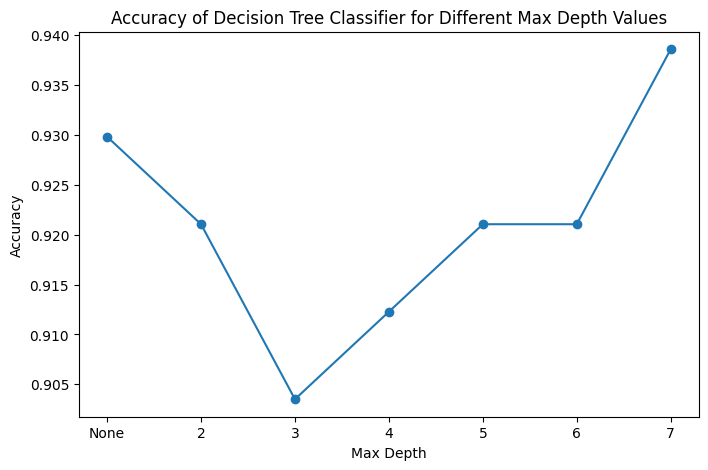

In [12]:
# Tạo một biểu đồ đường để hiển thị kết quả
plt.figure(figsize=(8, 5))
plt.plot(max_depth_values, accuracy_scores, marker='o', color='#1f77b4')
plt.title('Accuracy of Decision Tree Classifier for Different Max Depth Values')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()